<a href="https://colab.research.google.com/github/junaidrhmn/Deep_Learning/blob/main/Image%20Captioning/flickr8k%20and%20InceptionV3/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  !pip install -q kaggle
# from google.colab import files
# files.upload()
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d adityajn105/flickr8k

In [ ]:
# !cp '/content/flickr8k.zip' '/content/drive/MyDrive'

cp: cannot stat '/content/flickr8k.zip': No such file or directory


In [ ]:
!cp /content/drive/MyDrive/flickr8k.zip /content

In [ ]:
# !cp '/content/flickr8k/captions.txt' '/content/drive/MyDrive/dl .hs files/flick8k inceptionv3 image captioning'

In [1]:
!mkdir flickr8k

In [ ]:
!unzip '/content/flickr8k.zip' -d '/content/flickr8k'

Archive:  /content/flickr8k.zip
replace /content/flickr8k/Images/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


**Importing**

In [2]:
import os
import pickle
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Input, Dense, RepeatVector, Concatenate, Activation
from tensorflow.keras.layers import LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam

In [ ]:
data_dir = '/content/flickr8k'
images_dir = os.path.join(data_dir, 'Images')
caption_file = os.path.join(data_dir, 'captions.txt')

In [ ]:
# Create InceptionV3 model without the final classification layer
inception_model = InceptionV3(weights='imagenet')
inception_model = Model(inputs=inception_model.input, outputs=inception_model.layers[-2].output)
inception_model.summary()

In [ ]:
img_features = {}

for img_name in tqdm(os.listdir(images_dir)):
  img_path = os.path.join(images_dir,img_name)
  img = load_img(img_path, target_size=(299,299), color_mode = 'rgb')
  img = img_to_array(img)
  img = preprocess_input(img)
  img = img.reshape((1, 299, 299, 3))
  feature = inception_model.predict(img, verbose=0)
  img_features[img_name] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
# Save img_features using pickle
with open('/content/drive/MyDrive/dl .hs files/flick8k inceptionv3 image captioning/img_features.pkl', 'wb') as f:
    pickle.dump(img_features, f)


In [4]:
with open('/content/drive/MyDrive/dl .hs files/flick8k inceptionv3 image captioning/img_features.pkl', 'rb') as f:
    img_features = pickle.load(f)

In [5]:
!cp '/content/drive/MyDrive/dl .hs files/flick8k inceptionv3 image captioning/captions.txt' '/content/flickr8k'

In [6]:
with open('/content/flickr8k/captions.txt','r') as caption:
    caption_doc = caption.read()

**remove the header from the caption**

In [7]:
lines = caption_doc.split('\n')
caption_doc = lines[1:]

In [8]:
caption_doc[:5]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .']

In [9]:
import re

caption_dict = {}

for line in tqdm(caption_doc):
    tokens = line.split(',')

    if len(tokens) < 2:
        continue

    img_name, caption = tokens[0], tokens[1]

    # Preprocess the caption
    caption = caption.lower()
    caption = re.sub(r'[^a-z ]', '', caption)
    caption = re.sub(r'\s+', ' ', caption).strip()
    caption = 'startseq' + ' ' + caption + ' ' + 'endseq'

    if img_name not in caption_dict:
        caption_dict[img_name] = []
    caption_dict[img_name].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
caption_dict

In [ ]:
len(caption_dict)

8091

***Tokenizing***

In [10]:
all_captions = []

for key, caption in caption_dict.items():
  for i in caption:
    all_captions.append(i)

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(all_captions)
vocab_size = len((tokenizer.word_index))+1
print(vocab_size)

8589


In [11]:
# max_length of the caption
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

**Train Test Split**

In [12]:
img_name = list(caption_dict.keys())
split = int(len(img_name) * 0.90)
train = img_name[:split]
test = img_name[split:]

In [ ]:
train

In [ ]:
caption_dict['1000268201_693b08cb0e.jpg']

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq']

In [ ]:
img_features['1000268201_693b08cb0e.jpg'][0]

array([0.12277618, 0.33293068, 0.75272465, ..., 0.21941483, 0.30208516,
       0.40279675], dtype=float32)

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data, caption_dict, img_features, tokenizer, max_length, vocab_size, batch_size):
    feature_in, caption_inp, caption_out = list(), list(), list()
    n = 0
    while 1:
        for key in data:
            n += 1
            captions = caption_dict[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    feature_in.append(img_features[key][0])
                    caption_inp.append(in_seq)
                    caption_out.append(out_seq)
            if n == batch_size:
                feature_in, caption_inp, caption_out = np.array(feature_in), np.array(caption_inp), np.array(caption_out)
                yield [feature_in, caption_inp], caption_out
                feature_in, caption_inp, caption_out = list(), list(), list()
                n = 0

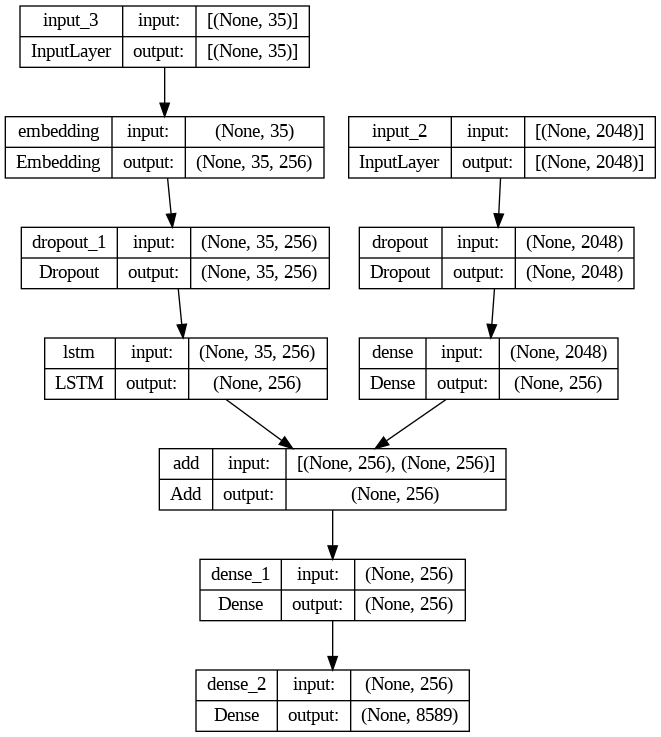

In [ ]:
# ENCODER LAYERS
# image feature layer
input1 = Input(shape=(2048,))
if1 = Dropout(0.4)(input1)
if2 = Dense(256, activation='relu')(if1)

# caption layer
input2 = Input(shape=(max_length,))
cg1 = Embedding(vocab_size, 256, mask_zero=True)(input2)
cg2 = Dropout(0.4)(cg1)
cg3 = LSTM(256)(cg2)

# DECORDER LAYERS
decoder1 = add([if2,cg3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs = [input1, input2], outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer='adam')

plot_model(model, show_shapes=True)

In [ ]:
epoch = 35
batch_size = 32
steps = len(train) // batch_size

for i in tqdm(range(epoch)):
  generator = data_generator(train, caption_dict, img_features, tokenizer, max_length, vocab_size, batch_size)
  model.fit(generator, epochs=1, steps_per_epoch = steps, verbose=1)

model.save('/content/drive/MyDrive/dl .hs files/flick8k inceptionv3 image captioning/best_model.h5')

  0%|          | 0/35 [00:00<?, ?it/s]

227/227 [==============================] - 67s 293ms/step - loss: 1.7104


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
model = load_model('/content/drive/MyDrive/dl .hs files/flick8k inceptionv3 image captioning/best_model.h5')

In [14]:
def predict_caption(model, image, tokenizer, max_length):
    generated_caption = 'startseq'

    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([generated_caption])[0]
        pad = pad_sequences([sequence], maxlen=max_length)
        word = model.predict([image, pad])
        word_index = np.argmax(word)
        word = tokenizer.index_word.get(word_index, None)

        if word is None:
            break
        else:
            generated_caption += ' ' + word

        if word == 'endseq':
            break

    return generated_caption


In [18]:
image_path = '/content/surf.jpg'
image = load_img(image_path, target_size=(299, 299), color_mode='rgb')
image = img_to_array(image)
image = preprocess_input(image)
image = image.reshape((1, 299, 299, 3))

# Extract features using the model
feature = model.predict(image, verbose=0)

# Generate caption
caption = predict_caption(model, feature, tokenizer, max_length)
print(caption)


ValueError: ignored